In [74]:
import seaborn as sns
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

from scipy.signal import square, stft
from scipy import constants 
from scipy import signal, fftpack
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import gaussian

import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, optimizers, callbacks
import tensorflow as tf
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_validate

from DataLoader import *

In [2]:
sleepy_list = [11, 18, 0, 12, 10, 11, 5, 11, 2, 5, 9, 9, 17, 4, 2, 12, 12, 19, 13, 7, 11, 3, 5, 14, 14, 14, 12, 13, 11, 1, 11, 13, 11, 8, 19, 21, 22, 16, 15, 12, 26, 4, 19, 21, 18, 20]

sleepy_df = pd.DataFrame(sleepy_list)

sleepy_df["fatigue"] = sleepy_df[0]

sleepy_df = sleepy_df.drop(columns=0)

sleepy_df["is_tired"] = 0

sleepy_df['is_tired'] = (sleepy_df['fatigue'] > 11).astype(int)

In [3]:
sleepy_df_6split = pd.DataFrame(np.repeat(sleepy_df.values, 6, axis=0))
sleepy_df_6split.columns = sleepy_df.columns
sleepy_df_6split.shape

(276, 2)

<Axes: ylabel='Count'>

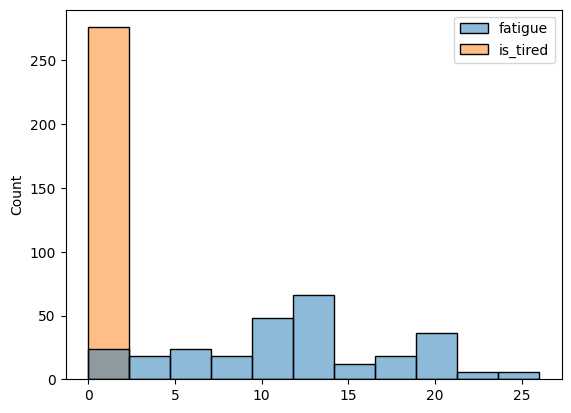

In [4]:
sns.histplot(sleepy_df_6split)

In [6]:
def normalization(subject):
    num_transformer=make_pipeline(StandardScaler())
    num_transformer.fit(subject)
    return pd.DataFrame(num_transformer.transform(subject), columns=subject.columns)

In [7]:
df_list = []

for walk in range(0,46):
        df = pd.read_csv(f"data2/{walk}.csv", names = ["x",
        "y", "z"], dtype=float)
                # Load the time when the data measurement started from the first
                # value in the first row of the csv file
        starting_time = df.iloc[0, 0]
                # Load the data sampling rate from the first value in the second
                # row of the csv file
        sampling_rate = df.iloc[1, 0]
                # Removes the first two rows of the DataFrame, as they contain
                # info about the measurment starting time and sampling rate
        df = df.tail(-2).reset_index(drop=True)
                # Determine the number of samples in the data
        number_of_samples = len(df)
                # Generate the time vector based on the measurement starting time
                # and sampling rate
        time_vector = np.arange(starting_time, starting_time + 
            number_of_samples / sampling_rate, 1 / sampling_rate)
                #Add the UNIX time vector to the Pandas DataFrame
        df["UNIX_time"] = time_vector
                # Calculate the total duration of the DataFrame (in seconds)
        total_duration = df['UNIX_time'].max() - df['UNIX_time'].min()
                # Calculate the start time for the 30-minute window (center of data)
        half_duration = total_duration / 2
        center_time = df['UNIX_time'].min() + half_duration
                # Define the 30-minute window
        window_start = center_time - 900  # 900 seconds = 30 minutes
        window_end = center_time + 900
                # Extract data within a 30-minute window located at the center of
                # original DataFrame
        df = df[(df['UNIX_time'] >= window_start) & (df['UNIX_time'] <= window_end)]
        
                # Return the desired data as a Pandas DataFrame
        df = df.drop(columns='UNIX_time')
        df = df.reset_index(drop=True)
        df = normalization(df)

                #divides each df into 6ths
        for chunk in range(6):
                #adds first 6th to the output list
                df_c = df[:9600]
                df_list.append(df_c)
                #discards first 6th
                df = df.iloc[9600:]

In [8]:
# Assuming each DataFrame has the same number of rows
# Convert the list of DataFrames to a 3D numpy array
X_tensor = np.array([df[['x', 'y', 'z']].values for df in df_list])

print(X_tensor.shape)  # Should print (46, number_of_rows, 3) #or 276 for 6ths

(276, 9600, 3)


In [9]:
sleepy_df_6split.shape

(276, 2)

In [ ]:
# X_test = X_tensor[:65,:,:]
# X_test.shape

In [ ]:
# X_train = X_tensor[65:,:,:]
# X_train.shape

In [ ]:
# y_test = sleepy_df_6split["is_tired"][:65]
# y_test.shape

In [ ]:
# y_train = sleepy_df_6split["is_tired"][65:]
# y_train.shape

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, sleepy_df_6split["is_tired"], test_size=0.3)
display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(193, 9600, 3)

(83, 9600, 3)

(193,)

(83,)

In [16]:
X_train[:,:,0].shape

(193, 9600)

<Axes: >

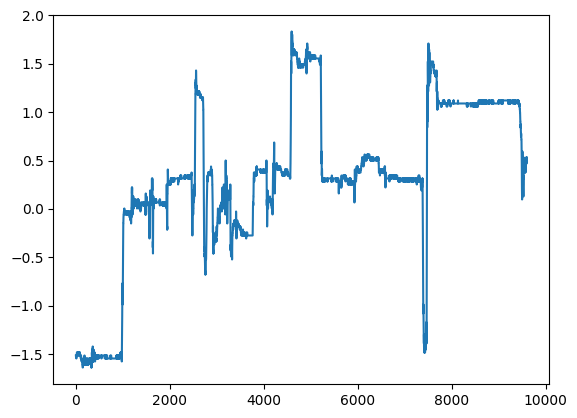

In [81]:
sns.lineplot(X_train[7,:,1])

In [24]:
# from p220 of "Hands-On" book

# the [:,:,2] is because it can't eat a whole tensor, this selects only the z-axis accel data


rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)

rnd_clf.fit(X_train[:,:,2], y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1)

In [25]:
y_pred = rnd_clf.predict(X_test[:,:,2])

accuracy_score(y_test, y_pred)

0.5783132530120482

In [66]:
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

output = cross_validate(rnd_clf, X_test[:,:,2], y_test, cv=k_fold, scoring = 'accuracy', return_estimator =True)

In [68]:
display(output)
display(output["test_score"].mean())

{'fit_time': array([0.35429096, 0.33759689, 0.344172  , 0.34786367, 0.32453418,
        0.34314513, 0.33296299, 0.32676601, 0.4472928 , 0.33433509]),
 'score_time': array([0.02883601, 0.02811193, 0.02777886, 0.02757907, 0.02675581,
        0.02830887, 0.0277791 , 0.02801585, 0.02614617, 0.0252862 ]),
 'estimator': [RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1),
  RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1),
  RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1),
  RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1),
  RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1),
  RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1),
  RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1),
  RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1),
  RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1),
  RandomForestClass

0.5180555555555555

In [82]:
#from p.234

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=2000)),
        ('rf', RandomForestClassifier()),
        ('svc', SVC(probability=True))],
    final_estimator = RandomForestClassifier(),
    cv=5
)

stacking_clf.fit(X_train[:,:,2], y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(max_iter=2000)),
                               ('rf', RandomForestClassifier()),
                               ('svc', SVC(probability=True))],
                   final_estimator=RandomForestClassifier())

In [83]:
y_pred = stacking_clf.predict(X_test[:,:,2])

accuracy_score(y_test, y_pred)

0.5783132530120482

In [ ]:
# input_shape=X_train.shape[1:]


# model = Sequential()

# # 1D Convolutional layer
# model.add(Conv1D(filters=64, kernel_size=32, activation='relu', kernel_regularizer=l1(0.001), input_shape=input_shape))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.2))

# # Another 1D Convolutional layer
# model.add(Conv1D(filters=96, kernel_size=32, kernel_regularizer=l1(0.001), activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.2))

# # LSTM layer (without flattening)
# model.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))
# model.add(Dropout(0.2))

# # Another LSTM layer
# model.add(LSTM(128, kernel_regularizer=l2(0.001)))
# model.add(Dropout(0.2))

# # Dense layer
# model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
# model.add(Dropout(0.2))

# # Output layer
# model.add(Dense(1, activation='sigmoid'))

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Summary of the model
# model.summary()


In [ ]:
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_split=0.2, shuffle=True, verbose=1)

# on my lappie, this takes over 30 seconds per epoch!

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

In [ ]:
metric = "accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()